# Simple EDA

In this Notebook, simple data exploration is presented with the goal of understanding if there are any variables that are tied to how likely it is for the contestants to beat the final chase.

Presented are
- Study of the player individual scores and earnings.
- Useful printouts of dataframe quantities
- Plots of the contestant win rate in various quantities
- A 2D pairplot of numeric quantities

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.sans-serif'] = "Helvetica Neue"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'errorbar.capsize': 3})


# DataFrame Inspection
Here doing the good practice head, info, describe to help understand what is in the dataframe.

For the sake of safety, we shall only perform EDA on 80% of the data (using the 80-20 rule of thumb), the same 80% we will use for model training in the modelling notebook, performed by using a set seed random shuffle. To allow enough statistics for each Chaser, choose to stratify on this.

In [2]:
full_df = pd.read_csv('data/parsed_chase.csv')
from sklearn.model_selection import train_test_split
df, test_df = train_test_split(full_df, test_size=0.2, random_state=1000, stratify=full_df["Chaser"])
print("Training Episodes: {}, Test Episodes: {}".format(len(df), len(test_df)))
df.head()

Training Episodes: 1163, Test Episodes: 291


,Series,Episode,AirDate,Chaser,P1,P2,P3,P4,NPlayers,PTotal,playerScore,chaserScore,playerWin,remainingTime
918,10,2,2016-04-18,Shaun Wallace,7000.0,4000.0,3000.0,7000.0,4.0,21000.0,19,19,False,4.0
253,8,109,2015-03-20,Anne Hegerty,6000,-,-,5,2.0,6005.0,9,9,False,43.0
1357,13,84,2020-03-09,Shaun Wallace,4000.0,5000.0,5000.0,4000.0,4.0,18000.0,12,12,False,56.0
1092,10,176,2017-04-24,Anne Hegerty,7000.0,4000.0,5000.0,4000.0,4.0,20000.0,13,13,False,11.0
493,3,19,2011-01-27,Shaun Wallace,7000.0,-,8000.0,9000.0,3.0,24000.0,27,15,True,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1163 entries, 918 to 922
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series         1163 non-null   int64  
 1   Episode        1163 non-null   int64  
 2   AirDate        1162 non-null   object 
 3   Chaser         1163 non-null   object 
 4   P1             1163 non-null   object 
 5   P2             1163 non-null   object 
 6   P3             1163 non-null   object 
 7   P4             1163 non-null   object 
 8   NPlayers       1163 non-null   float64
 9   PTotal         1163 non-null   float64
 10  playerScore    1163 non-null   int64  
 11  chaserScore    1163 non-null   int64  
 12  playerWin      1163 non-null   bool   
 13  remainingTime  1163 non-null   float64
dtypes: bool(1), float64(3), int64(4), object(6)
memory usage: 128.3+ KB


In [4]:
df.describe()

,Series,Episode,NPlayers,PTotal,playerScore,chaserScore,remainingTime
count,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000,1163.000000
mean,9.004299,78.447979,2.349957,18288.178848,16.210662,15.337059,22.869304
std,2.839205,50.642393,0.974091,16971.465533,3.713189,3.438903,21.481172
min,2.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000
25%,7.000000,34.000000,2.000000,8000.000000,14.000000,13.000000,1.000000
50%,9.000000,74.000000,2.000000,12300.000000,16.000000,15.000000,20.000000
75%,11.000000,119.000000,3.000000,20000.000000,19.000000,18.000000,37.000000
max,13.000000,200.000000,4.000000,101000.000000,28.000000,27.000000,108.000000


# Contestant 1 v 1 Earnings

Here we shall investigate the P1, P2, P3, P4 quantities, which reflect the 4 contestants (players for P players). These quantities say whether a player succesfully beat the chaser in their own round or not, and if so, how much money they bought back to cash pot.

<img src="assets/thechase_screen.jpg">

The bulk of the show consists of each contestant facing the chaser in this 1 vs 1 situation. And plays out like so:

- Contestant is asked questions for 60 seconds, they earn £1000 for each correct answer.
- The contestant is then required to face the chaser, multiple choice questions are presented and the contestant / chaser are required to answer them, each correct answer pushes the contestant / chaser down the board, one step closer to securing their place in the final chase. Each incorrect answer keeps them at the same step.
    - If the chaser catches up to the contestant (contestant gets answers incorrect while chaser gets them correct) they are out of the game.
    - If the contestant reaches the bottom of the board they have succesfully secured their place in the final chase and their earnings are added to the players cash pot. 
- By default the contestant has to answer 5 questions correctly, however the chaser will allow the contestant to start one step further away (6 questions) or one step closer (4 questions), but allowing for a change in their earnings.


The chasers use this to try and tempt good players into taking a risk of the higher offer, as well as penalising the team by allowing less succesfull players to get back, but with negative contributions to the total cash pot.

## P1, P2, P3, P4 Differences

The chasers tend to adapt their offers depending on how the previous contestants have performed, for example
- Contestant 1 is never offered a negative lower offer
- The Higher offers generally increase for Contestant 3 and 4

We do not actually have information on whether the contestant chose the higher or lower offer, only their earnings if successful, or a "did not finish" label. The obvious solution is, rewatch every episode and collect this data... however as we can only work with what we have, can we see any obvious distinctions in earnings by histogramming the succesfull earnings? Is there any difference when plotting each contestant number separately?

For easier plotting I have split these plots to show, (P1 and P2), (P3 and P4) offers above 20k, and offers below 20k

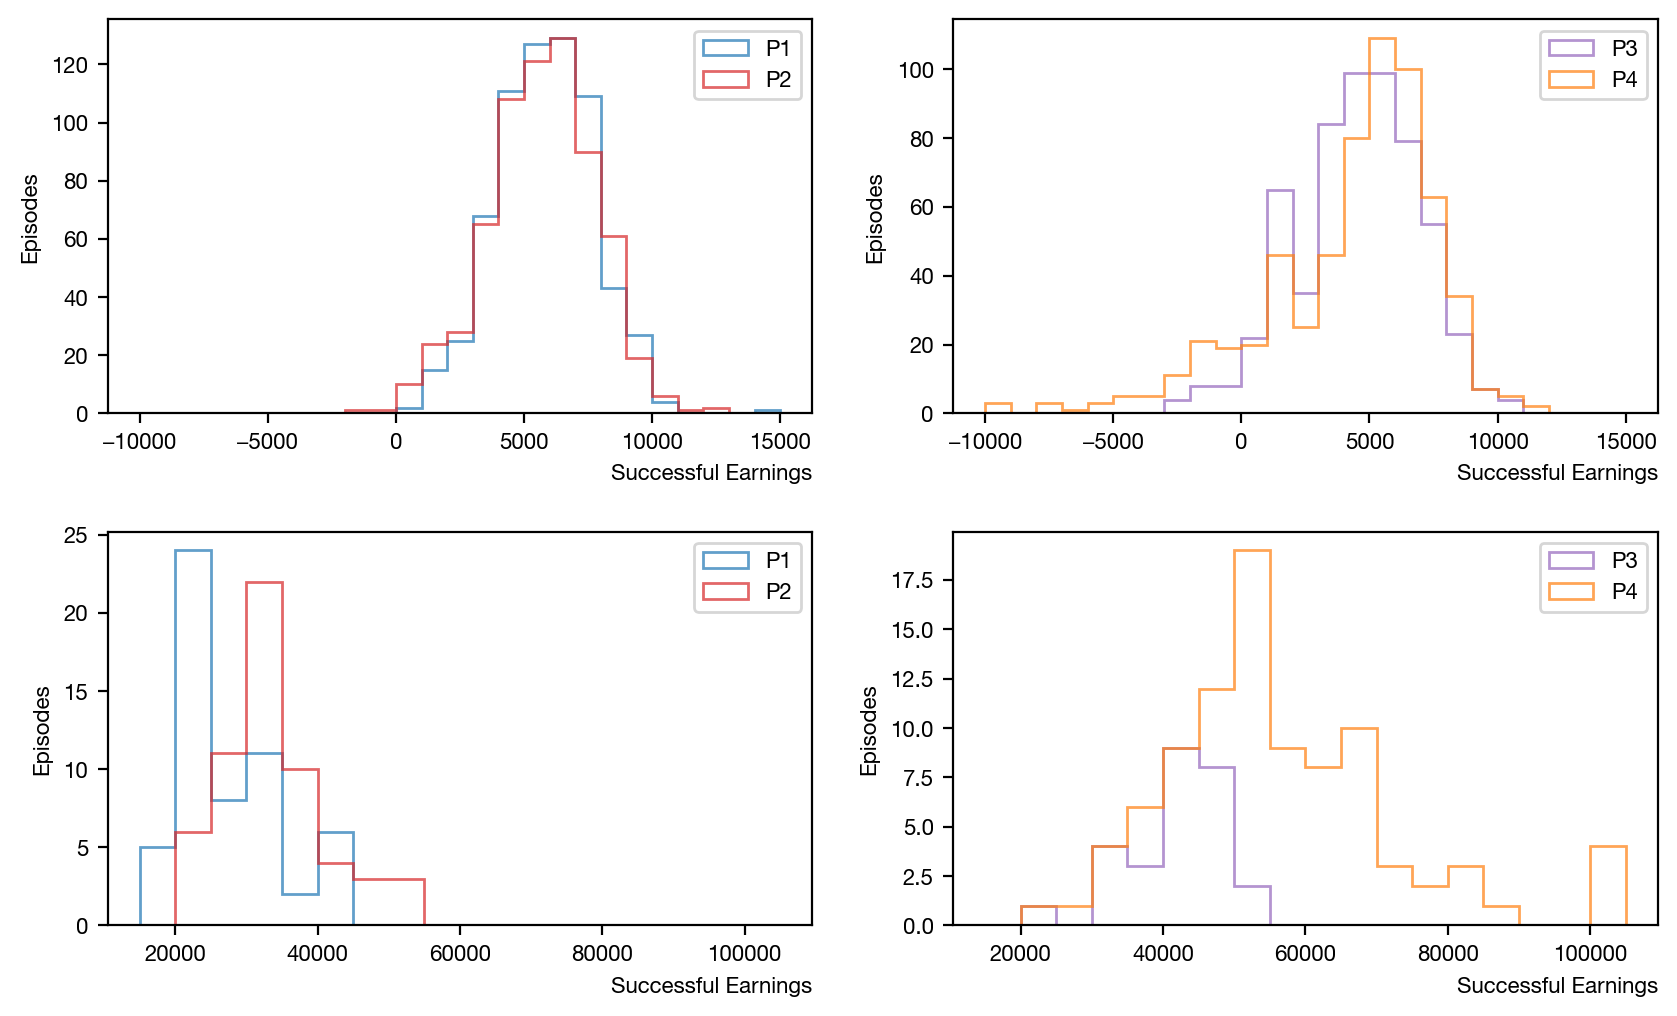

In [5]:
p_colours = {"P1": "tab:blue", "P2": "tab:red", "P3": "tab:purple", "P4": "tab:orange"}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=.3)

binning_low = np.linspace(-10000,15000, 26)
binning_high = np.linspace(15000,105000, 19)

players = ["P1", "P2"]
for p in players:
    df[p][df[p] != "-"].astype(float).hist(bins=binning_low, label=p, histtype=u'step', alpha=0.7, ax=ax1, color=p_colours[p])
    df[p][df[p] != "-"].astype(float).hist(bins=binning_high, label=p, histtype=u'step', alpha=0.7, ax=ax3, color=p_colours[p])
    
players = ["P3", "P4"]
for p in players:
    df[p][df[p] != "-"].astype(float).hist(bins=binning_low, label=p, histtype=u'step', alpha=0.7, ax=ax2, color=p_colours[p])
    df[p][df[p] != "-"].astype(float).hist(bins=binning_high, label=p, histtype=u'step', alpha=0.7, ax=ax4, color=p_colours[p])

for a in [ax1, ax2, ax3, ax4]:
    a.legend()
    a.set_yscale('linear')
    a.grid(b=False)
    label = a.xaxis.get_label()
    x_lab_pos, y_lab_pos = label.get_position()
    label.set_position([1.0, x_lab_pos])
    label.set_horizontalalignment('right')
    a.xaxis.set_label(label)
    a.set_xlabel("Successful Earnings")
    a.set_ylabel("Episodes")
plt.show()

This shows that P4 and P3 are more likely to return with a large or negative sum of money than P1 and P2, though it should be noted from the information we have it's not so obvious whether this is arising from changes in what is offered / changed in circumstances.

To account for having "Did not Finish" category, it makes sense to turn these counts into a categorical variable. The boundaries for such could be approximated with a sophisticated KDE method, however by eye some noticeable choices can be deduced. These will be used in the modelling notebook.

- Larger than £14000
- Lower than £2000
- Between £2000 and £14000
- Did Not Finish

Finally we should check the "Did not Finish" category, i.e. how many of each contestant number actually returned succesfully.

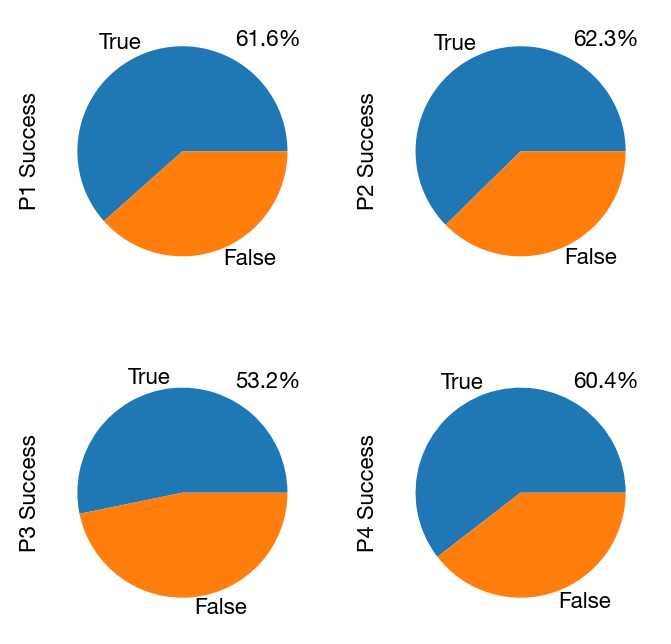

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
fig.subplots_adjust(hspace=.3)

players = ["P1", "P2", "P3", "P4"]
axes_list = [ax1, ax2, ax3, ax4]
for i, p in enumerate(players):
    did_finish = df.copy()
    did_finish["Success"] = (did_finish[p] != "-")
    temp = did_finish["Success"].groupby(did_finish["Success"]).sum()
    did_finish["Success"].value_counts().plot.pie(figsize=(4, 4), label=p + " Success", ax=axes_list[i])

    percentage = 100*did_finish["Success"].sum() / len(did_finish["Success"])
    
    axes_list[i].text(0.5, 1, "{:.1f}%".format(percentage))

These are all quite consistent however P3 seems to have a lower success rate? Interesting.

# Win Rate Plots

First let's study how these parameters influence the chance of contestants winning.

### Generic WinRate Plotting Function

Here define a function that takes in a pandas groupby object, calculates the win rate for each group, then plots.

In [7]:
def plot_groupby_winrates(chasers_group, figsize=(8,4), dpi=200, label=None, xlabel=None, ylabel=None, xlim=None, ylim=None):
    """
    Given a pandas groupby object, produce a plot of contestant win rate split by group.
    Additional inputs for plotting labels.
    """
    
    fig, ax=plt.subplots(dpi=dpi)
        
    # Calculate win rate. Using binomial fraction calculation, output in percentage
    winrate_df = pd.DataFrame()
    winrate_df["winRate"] = chasers_group["playerWin"].sum()/chasers_group["playerWin"].count()
    winrate_df["winRateErr"] = (winrate_df["winRate"]*(1-winrate_df["winRate"])/chasers_group["playerWin"].count())**0.5
    winrate_df["winRate"] = winrate_df["winRate"]*100
    winrate_df["winRateErr"] = winrate_df["winRateErr"]*100
    
    # Assign an index label for each group
    plot_index = list(chasers_group.groups.keys())
    plot_index = [x.mid if type(x) == pd._libs.interval.Interval else x for x in plot_index]
    winrate_df = winrate_df.reset_index(drop=True)
    winrate_df["plot_index"] = plot_index

    winrate_df.plot(
        kind="scatter", marker='s', s=8, 
        x="plot_index", y="winRate", yerr="winRateErr", 
        figsize=figsize, xlim = xlim, ylim=ylim, ax=ax
    )
    
    
    if label != None:
        ax.legend([label])
    
    plt.xlabel(xlabel, horizontalalignment='right', x=1.0)
    plt.ylabel(ylabel, horizontalalignment='left', x=1.0)
    
    ax.tick_params(direction='in', length=2 )
    #ax.tick_params(axis="x", labelsize=8)
    #ax.tick_params(axis="y", labelsize=8)
    
    plt.show()

## Win Rate by Chaser

First we want to visualise the contestant win rates when facing each chaser. What we see immediately is that there is some variablity here

Contestants are...
- Least successful against Anne Hegerty 
- Most successful against Shaun Wallace


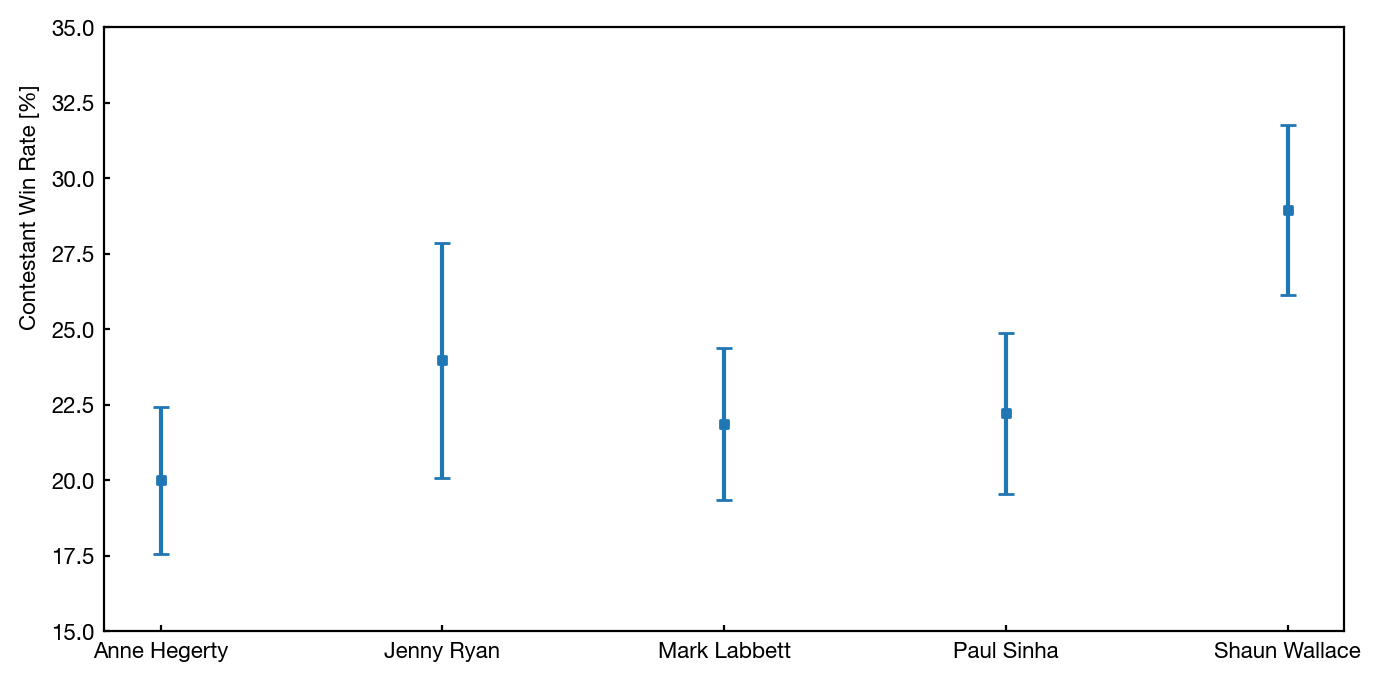

In [8]:
plot_groupby_winrates(df.groupby(['Chaser']), ylabel="Contestant Win Rate [%]", ylim=[15,35], figsize=(8,4), dpi=200)

## Win Rate by Number of Contestants in Final Chase

Next let's visualise the contestant win rates vs how many contestants are in the final chase.

Generally we see the more contestants there are, the higher success rate. This catches two effects:
- Each succesfull contestant is awared a 1 question headstart, with all 4 succesful they begin with a score of 4 already achieved.
- If all contestants are in the Final Chase, they were all smart enough to beat the chaser in their individual round.

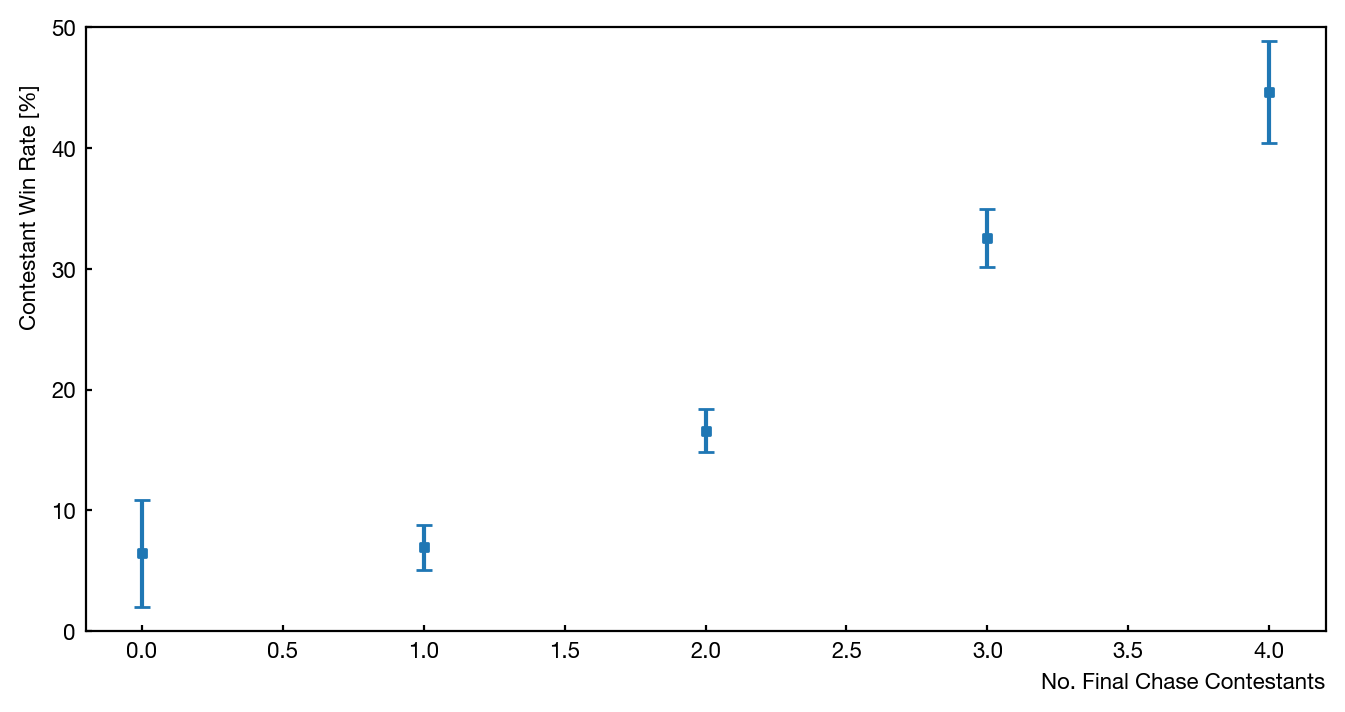

In [9]:
plot_groupby_winrates(df.groupby(['NPlayers']), xlabel="No. Final Chase Contestants", ylabel="Contestant Win Rate [%]", ylim=[0,50], figsize=(8,4), dpi=200)

## Win Rate by Contestant Final Chase Score

Next let's visualise the contestant win rates vs their score in the final chase. This is quite easy to get a good feeling for just by watching. The higher the score, the more work the Chaser needs to put in to win.

This is reflected quite well, with a strong slope arising after a score of around 15, below which the chance of winning is essentially zero.

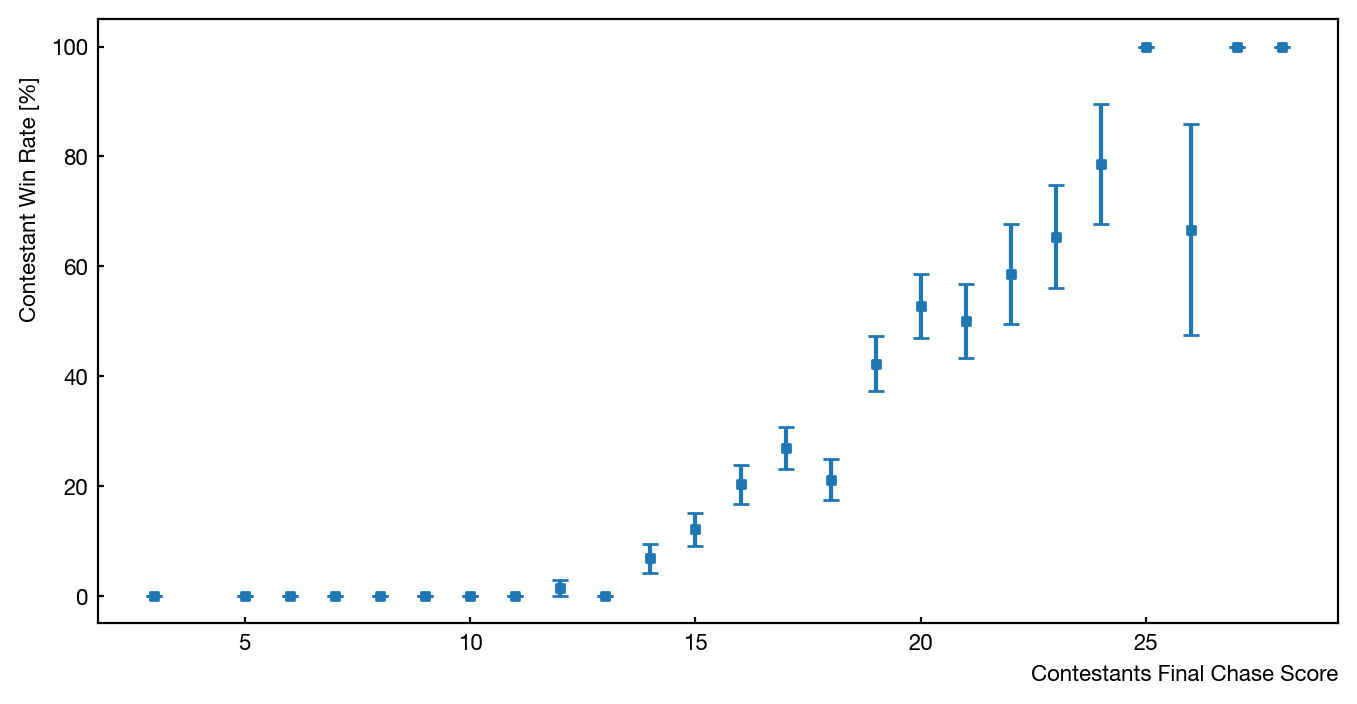

In [10]:
plot_groupby_winrates(df.groupby(['playerScore']), xlabel="Contestants Final Chase Score", ylabel="Contestant Win Rate [%]", figsize=(8,4), dpi=200)

### Per Chaser Features

Producing this plot for each chaser some interesting results arise. This dip at score=18 seems to be strongly influenced by Mark Labbett, and mildly also by Jenny Ryan. It is however only ~2sigma so not something to read into too much.

We also see Shaun Wallace has a distribution that differs from the others, at score=21-23 the player win-rates are curiously lower than the others, but for the bulk region score=15-20 the players have a much stronger chance of winning in comparison with other chasers.

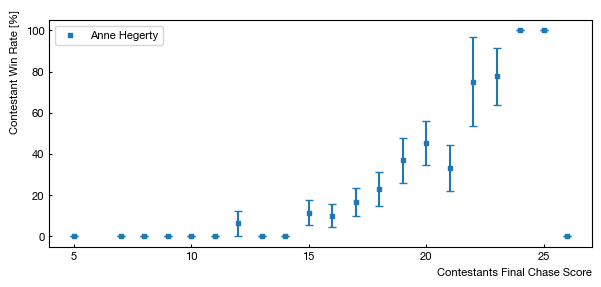

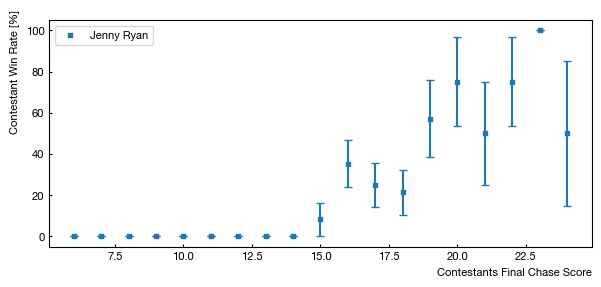

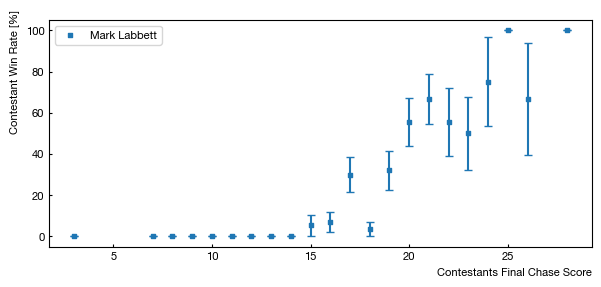

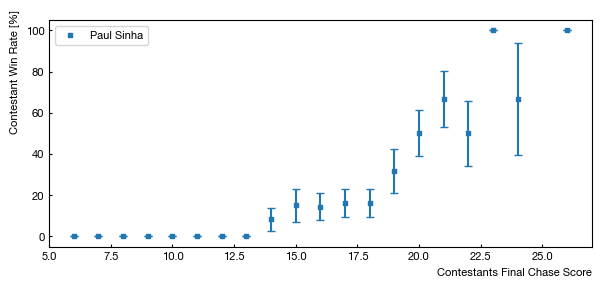

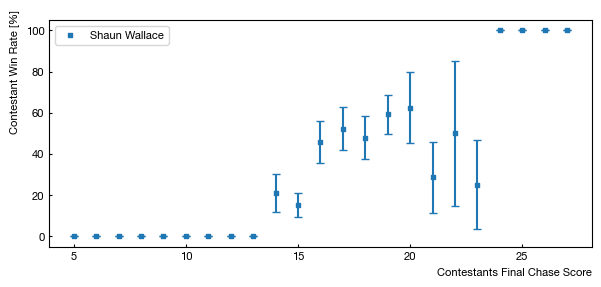

In [11]:
chasers = ["Anne Hegerty", "Jenny Ryan", "Mark Labbett", "Paul Sinha", "Shaun Wallace"]
for i, c in enumerate(chasers):
    plot_groupby_winrates(df[df["Chaser"] == c].groupby(['playerScore']), label=c, xlabel="Contestants Final Chase Score", ylabel="Contestant Win Rate [%]", figsize=(7,3), dpi=100)
    plt.show()
    #plt.show()

# PairPlot

Producing a pairplot separated on whether the contestants win or lose to see if there are any strong discrimination variables in 2-dimensions.

The strongest separation can be seen in the variables:
- PTotal 
- NPlayers
- playerScore

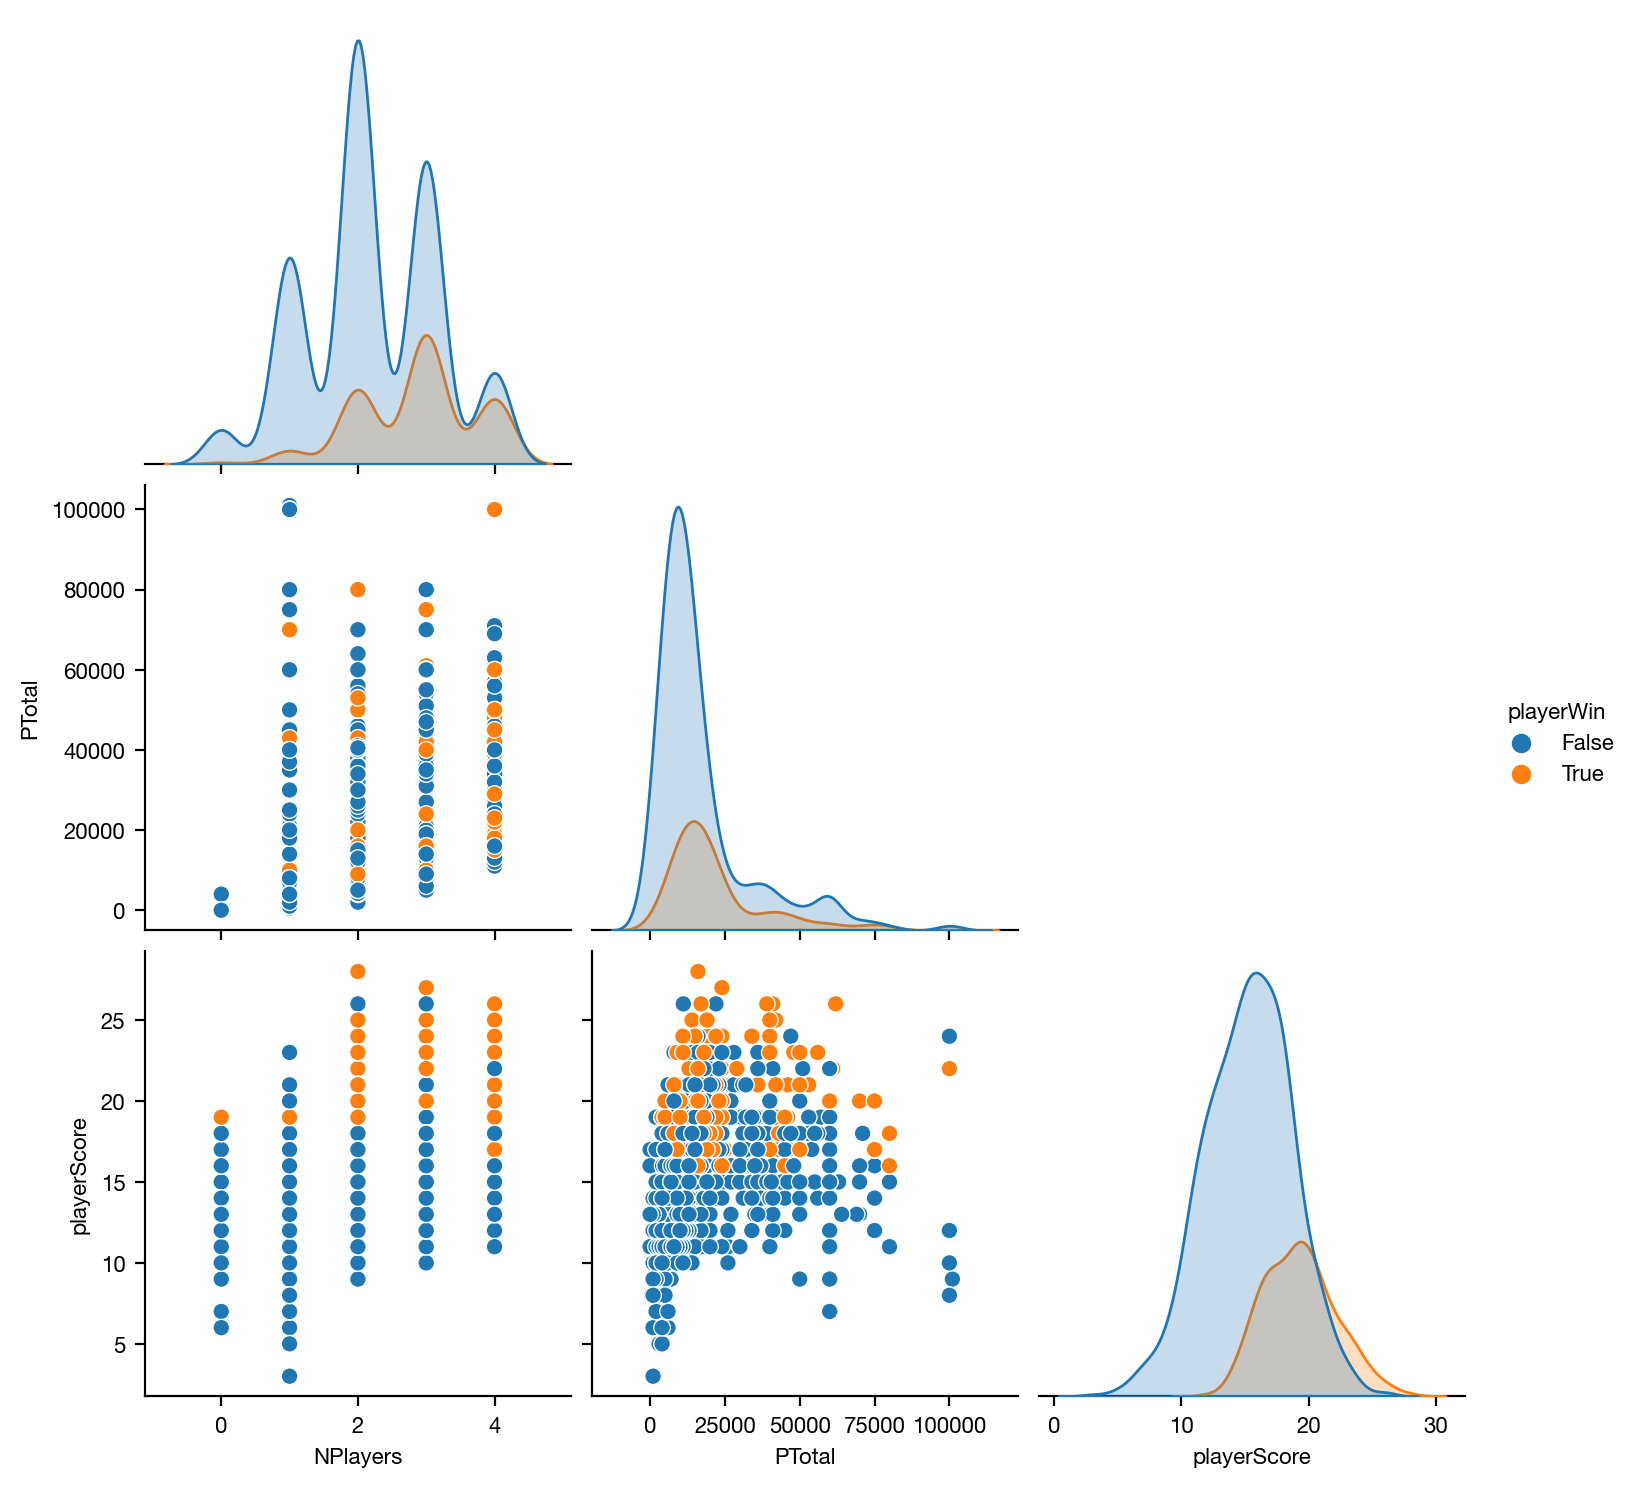

In [12]:
pair_df = df.copy()
pair_df = pair_df.drop(columns=['Series', 'Episode', 'AirDate', 'Chaser', 'chaserScore', 'remainingTime'])
sns.pairplot(pair_df, hue="playerWin", corner=True)